In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install demoji

import re
import demoji
import random
import inflect
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, random_split

In [ ]:
# Reading the text
file_path = "/content/drive/MyDrive/human_chat.txt"
with open(file_path, "r") as file:
  lines = file.readlines()

In [ ]:
lines

['Human 1: Hi!\n',
 'Human 2: What is your favorite holiday?\n',
 'Human 1: one where I get to meet lots of different people.\n',
 'Human 2: What was the most number of people you have ever met during a holiday?\n',
 'Human 1: Hard to keep a count. Maybe 25.\n',
 'Human 2: Which holiday was that?\n',
 'Human 1: I think it was Australia\n',
 'Human 2: Do you still talk to the people you met?\n',
 "Human 1: Not really. The interactions are usually short-lived but it's fascinating to learn where people are coming from and what matters to them\n",
 'Human 2: Yea, me too. I feel like God often puts strangers in front of you, and gives you an opportunity to connect with them in that moment in deeply meaningful ways. Do you ever feel like you know things about strangers without them telling you?\n',
 'Human 1: what do you mean?\n',
 'Human 2: I think it\'s like a 6th sense, often seen as "cold readings" to people, but can be remarkably accurate. I once sat next to a man in a coffee and I felt

In [ ]:
len(lines)

1495

In [ ]:
def preprocess_text(text):
        # Remove HTML tags
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text()

        p = inflect.engine() #101
        demoji.download_codes()
        # Remove emojis
        text = demoji.replace(text, "")

        # Remove mentions of "Human 1" and "Human 2"
        text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)

        # Replace numbers with words
        text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)

        # Remove special characters, keeping only alphabetic and spaces
        text = re.sub('[^a-zA-Z\s]', ' ', text)

        # Replace specific unicode spaces with standard spaces and trim
        text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

        return text

In [ ]:
preprocessed_lines = [preprocess_text(line) for line in lines]

<ipython-input-6-77499133746e>:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()
<ipython-input-6-77499133746e>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
preprocessed_lines[0:5]

['Hi',
 'What is your favorite holiday',
 'one where I get to meet lots of different people',
 'What was the most number of people you have ever met during a holiday',
 'Hard to keep a count  Maybe twenty five']

In [ ]:
tokenizer = get_tokenizer('basic_english')
tokenized_conv = [tokenizer(conv) for conv in preprocessed_lines]

In [ ]:
tokenized_conv[3]

['what',
 'was',
 'the',
 'most',
 'number',
 'of',
 'people',
 'you',
 'have',
 'ever',
 'met',
 'during',
 'a',
 'holiday']

In [ ]:
features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1,
    specials=['<pad>', '<oov>'],
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1
)

In [ ]:
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

In [ ]:
print("Features Vocab Length", features_vocab_total_words)
print("Target_vocab_Length", target_vocab_total_words)

Features Vocab Length 2749
Target_vocab_Length 2747


In [ ]:
# making ngrams from the conversations
def make_ngrams(tokenized_text):
    list_ngrams = []
    for i in range(1, len(tokenized_text)):
        ngram_sequence = tokenized_text[:i+1]
        list_ngrams.append(ngram_sequence)
    return list_ngrams

In [ ]:
ngrams_list = []
for tokenized_con in tokenized_conv:
    ngrams_list.extend(make_ngrams(tokenized_con))

In [ ]:
# Add Random oov tokens to let the model handle oov tokens
def add_random_oov_tokens(ngram):
    for idx, word in enumerate(ngram[:-1]):
        if random.uniform(0, 1) < 0.1:
            ngram[idx] = '<oov>'
    return ngram

In [ ]:
ngrams_list_oov = []
for ngram in ngrams_list:
    ngrams_list_oov.append(add_random_oov_tokens(ngram))
print(any('<oov>' in ngram for ngram in ngrams_list_oov))

True


`get_itos`: stands for "index-to-string". The method returns a list where the indices in the list correspond to the numerical indices used in your model, and the values at those indices are the actual string representations (tokens).

In [ ]:
def text_to_numerical_sequence(tokenized_text):
    tokens_list = []
    if tokenized_text[-1] in target_vocab.get_itos():
        for token in tokenized_text[:-1]:
            num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_text[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None

In [ ]:
input_sequences = [text_to_numerical_sequence(sequence) for sequence in ngrams_list_oov if text_to_numerical_sequence(sequence)]

In [ ]:
print(f'Total input sequences: {len(input_sequences)}')
print(input_sequences[7:9])

Total input sequences: 18562
[[1, 90, 2, 1, 2], [56, 90, 2, 73, 4, 228]]


In [ ]:
X = [sequence[:-1] for sequence in input_sequences]
y = [sequence[-1] for sequence in input_sequences]
len(X[0]), y[0]

(1, 11)

In [ ]:
print(X[3],y[3])

[12, 13, 29, 120] 312


In [ ]:
longest_sequence_feature = max(len(sequence) for sequence in X)
longest_sequence_feature

153

In [ ]:
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature - len(sequence),0), value=0) for sequence in X]
padded_X[1], X[2], len(padded_X[1])

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0, 12, 13]),
 [12, 1, 29],
 153)

In [ ]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)
type(y), type(padded_X)

(torch.Tensor, torch.Tensor)

In [ ]:
y_one_hot = one_hot(y, num_classes=target_vocab_total_words)

In [ ]:
data = TensorDataset(padded_X, y_one_hot)

In [ ]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32

In [ ]:
train_data, test_data = random_split(data, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class My_BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [ ]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
epochs = 50

In [ ]:
model = My_BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model.to(device)

My_BiLSTM(
  (embedding): Embedding(2749, 128)
  (lstm): LSTM(128, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=2747, bias=True)
)

In [ ]:
def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
all_accuracies = []
all_losses = []
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracy(model, train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())

Epoch 0/50, Loss: 9.4477, Train K-Accuracy: 20.43%
Epoch 5/50, Loss: 3.5769, Train K-Accuracy: 47.26%
Epoch 10/50, Loss: 3.7065, Train K-Accuracy: 81.02%
Epoch 15/50, Loss: 1.0743, Train K-Accuracy: 90.84%
Epoch 20/50, Loss: 3.3778, Train K-Accuracy: 94.28%
Epoch 25/50, Loss: 2.2971, Train K-Accuracy: 95.23%
Epoch 30/50, Loss: 0.0918, Train K-Accuracy: 95.73%
Epoch 35/50, Loss: 0.0700, Train K-Accuracy: 95.81%
Epoch 40/50, Loss: 1.5571, Train K-Accuracy: 95.89%
Epoch 45/50, Loss: 0.0108, Train K-Accuracy: 95.94%


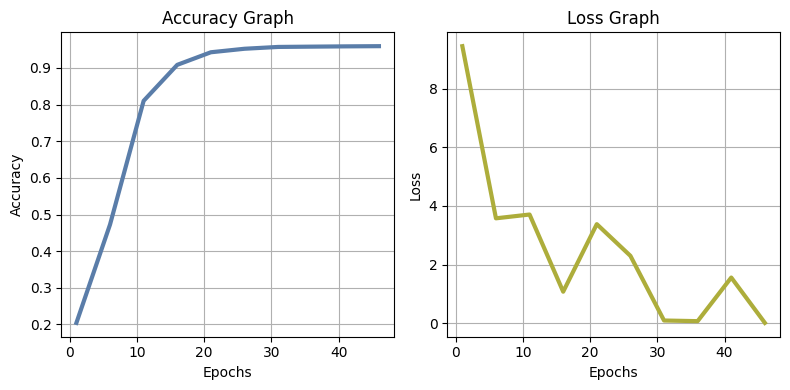

In [ ]:
epoch_list = [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)

axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
accuracy = calculate_topk_accuracy(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')

Test K-Accuracy: 20.06%


In [ ]:
model_path = '/content/drive/MyDrive/Next_Word_Save_Model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to /content/drive/MyDrive/Next_Word_Save_Model.pth


In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [ ]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
saved_model = BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim)

In [ ]:
model_path = '/content/drive/MyDrive/Next_Word_Save_Model.pth'
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list

In [ ]:
def use_model(input_list, top_k=5):
    saved_model.eval()
    output_list = []
    for data in input_list:
        sentence = data[0]
        num_words = data[1]
        for i in range(num_words):
            output_of_model = []
            tokenized_input_test = tokenizer(sentence)
            tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
            padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test),
                                                         (longest_sequence_feature - len(tokenized_sequence_input_test)-1, 0),
                                                         value=0)
            output_test_walking = model(padded_tokenized_sequence_input_test.unsqueeze(0))
            # Get the top k predictions and their indices
            top_predictions = torch.topk(output_test_walking, top_k)
            # Iterate over the top predictions
            for index in top_predictions.indices.squeeze():
                # Lookup the token for each index and append it to the output sentence
                sentence_with_predictions = sentence + ' ' + target_vocab.lookup_token(index.item())
                output_list.append(sentence_with_predictions)
        # Update the input sentence with the last predicted word
        sentence = output_list[-1]
    return output_list

In [ ]:
input_test = [['Hi', 1], ['Hello', 1]]

In [ ]:
outputs_model = use_model(input_test,5)
outputs_model

['Hi how',
 'Hi there',
 'Hi what',
 'Hi this',
 'Hi are',
 'Hello how',
 'Hello who',
 'Hello there',
 'Hello i',
 'Hello deja']